# Laboratorium 5 – Przestrzenie ciągłe

## Autorzy
- Kacper Cienkosz
- Miłosz Dubiel

In [55]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DDPG
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.monitor import load_results

In [56]:
def plot_mean_std_rewards(results):
    grouped_stats = results.groupby('index')['r'].agg(['mean', 'std']).reset_index()
    
    fig, ax1 = plt.subplots()

    # Plot mean values
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Mean', color='tab:blue')
    ax1.bar(grouped_stats['index'], grouped_stats['mean'], color='tab:blue', alpha=0.6, label='Mean')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create a secondary y-axis to plot standard deviation
    ax2 = ax1.twinx()
    ax2.set_ylabel('Standard Deviation', color='tab:red')
    ax2.plot(grouped_stats['index'], grouped_stats['std'], color='tab:red', marker='o', linestyle='-', linewidth=2, label='Standard Deviation')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Add legends
    # ax1.legend(loc='upper left')
    # ax2.legend(loc='upper right')
    
    # Show the plot
    plt.title('Mean and Standard Deviation of reward grouped by index')
    plt.show()

### Common hyperparameters

In [ ]:
N_ENVS = 10
N_TIMESTEPS = 15_000 * N_ENVS
POLICY = "MlpPolicy"

## Environment 1

### Hyperparameters

In [14]:
hyperparams1 = dict(
    learning_rate=1e-3,
    batch_size=256,
    train_freq=1,
    gradient_steps=1,
    action_noise=OrnsteinUhlenbeckActionNoise(
        mean=np.zeros(1),
        sigma=0.5 * np.ones(1),
    )
)

### Create the env

In [15]:
vec_env1 = make_vec_env("MountainCarContinuous-v0", n_envs=N_ENVS, monitor_dir='./monitor/mountain_car_ddpg_1')
model1 = DDPG(POLICY, vec_env1, verbose=1, **hyperparams1)

Using cpu device


### Learn the agent

In [16]:
model1.learn(total_timesteps=N_TIMESTEPS)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 954      |
|    ep_rew_mean     | -15.5    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2224     |
|    time_elapsed    | 4        |
|    total_timesteps | 9990     |
| train/             |          |
|    actor_loss      | -0.107   |
|    critic_loss     | 0.061    |
|    learning_rate   | 0.001    |
|    n_updates       | 988      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 954      |
|    ep_rew_mean     | -15.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2224     |
|    time_elapsed    | 4        |
|    total_timesteps | 9990     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 871      |
|    ep_rew_mean     | 2.4      |
| time/       

### Save the model

In [59]:
model1.save("./models/mountain_car_ddpg_1")

### Play the env

In [0]:
# obs = vec_env1.reset()
# 
# while True:
#     action, _states = model1.predict(obs)
#     obs, rewards, dones, info = vec_env1.step(action)
#     vec_env1.render("human")

### Plot the mean reward and standard deviation per episode

In [23]:
folder1 = './monitor/mountain_car_ddpg_1'
results1 = load_results(folder1)

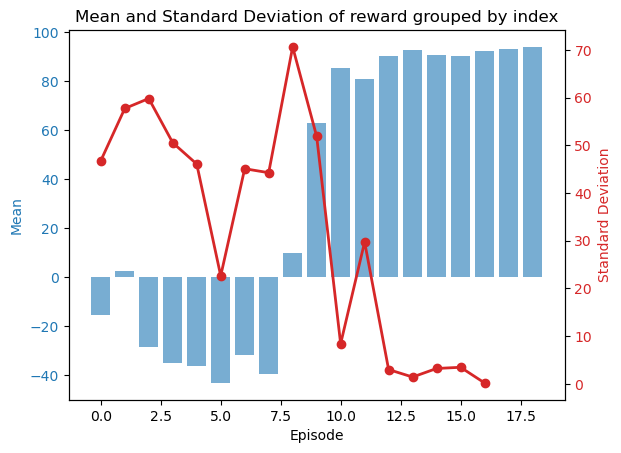

In [57]:
plot_mean_std_rewards(results1)

# Environment 2

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 943      |
|    ep_rew_mean     | -9.69    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2694     |
|    time_elapsed    | 3        |
|    total_timesteps | 9990     |
| train/             |          |
|    actor_loss      | -0.0233  |
|    critic_loss     | 0.000628 |
|    learning_rate   | 0.01     |
|    n_updates       | 988      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 943      |
|    ep_rew_mean     | -9.69    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2694     |
|    time_elapsed    | 3        |
|    total_timesteps | 9990     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 971      |
|    ep_rew_mean     | -12.7   

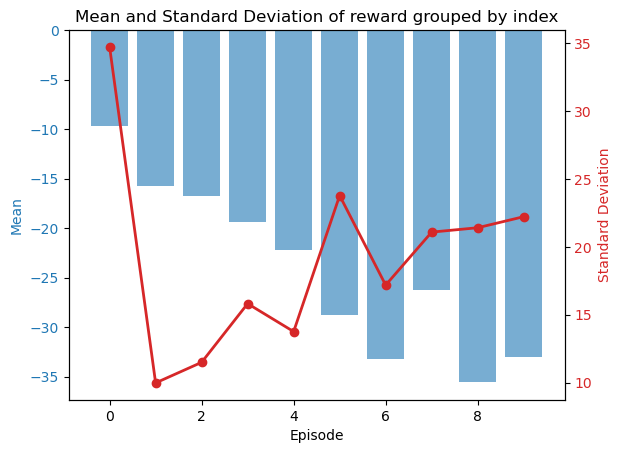

In [62]:
hyperparams2 = dict(
    learning_rate=0.01,
    batch_size=128,
    gamma=0.9,
    action_noise=OrnsteinUhlenbeckActionNoise(
        mean=np.zeros(1),
        sigma=0.3 * np.ones(1),
    )
)

vec_env2 = make_vec_env("MountainCarContinuous-v0", n_envs=N_ENVS, monitor_dir='./monitor/mountain_car_ddpg_2')
model2 = DDPG(POLICY, vec_env2, verbose=1, **hyperparams2)

model2.learn(total_timesteps=N_TIMESTEPS)

model2.save("./models/mountain_car_ddpg_2")

folder2 = './monitor/mountain_car_ddpg_2'
results2 = load_results(folder2)
plot_mean_std_rewards(results2)

# Environment 3

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -84.1    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2775     |
|    time_elapsed    | 3        |
|    total_timesteps | 9990     |
| train/             |          |
|    actor_loss      | 10.1     |
|    critic_loss     | 0.000625 |
|    learning_rate   | 0.01     |
|    n_updates       | 988      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -84.1    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2775     |
|    time_elapsed    | 3        |
|    total_timesteps | 9990     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -82.7   

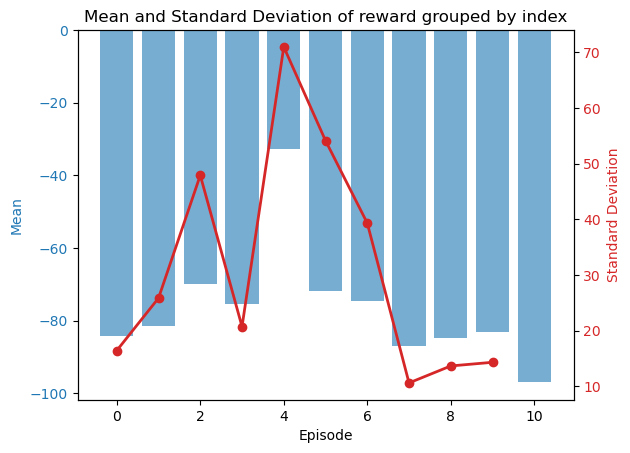

In [63]:
hyperparams3 = dict(
    learning_rate=0.01,
    batch_size=128,
    action_noise=OrnsteinUhlenbeckActionNoise(
        mean=np.zeros(1),
        sigma=0.2 * np.ones(1),
    ),
    tau=0.8
)

vec_env3 = make_vec_env("MountainCarContinuous-v0", n_envs=N_ENVS, monitor_dir='./monitor/mountain_car_ddpg_3')
model3 = DDPG(POLICY, vec_env3, verbose=1, **hyperparams3)

model3.learn(total_timesteps=N_TIMESTEPS)

model3.save("./models/mountain_car_ddpg_3")

folder3 = './monitor/mountain_car_ddpg_3'
results3 = load_results(folder3)
plot_mean_std_rewards(results3)